# Using D-FINE, a SoTA object detection model to train a given image dataset
## Actual Problem Statement: Cleaning a Contaminated Image Classification Dataset Using Object Detection

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import shutil
from pathlib import Path

In [2]:
"""
    1. Original (Contaminated) Folder:
        - bg_dir (str): folder containing background images
        - fb_dir (str): folder containing football images
    2. All image file names(titles):
        - bg_file_names (list): contains the actual file titles/names for background images
        - fb_file_names (list): contains the actual file titles/names for football images
"""
bg_dir = './contaminated_classifier_data/background'
fb_dir = './contaminated_classifier_data/football'

bg_file_names = []
fb_file_names = []

def extract_file_names(dir_loc):
    """
    Extracts the file titles for all the files in a directory
    
    Args:
        dir_loc (str): directory path

    Returns:
        list: list of all the file names
    """
    if dir_loc is None:
        return []
    
    file_names_ls = []
    
    # i'm assuming we only have jpg files
    file_names_ls = glob.glob(os.path.join(dir_loc, '*'))
    return file_names_ls
    
bg_file_names = extract_file_names(bg_dir)
fb_file_names = extract_file_names(fb_dir)

### checking number of images per folder

In [3]:
jpg_bg_files = [file for file in bg_file_names if file.endswith('.jpg')]
jpg_fb_files = [file for file in fb_file_names if file.endswith('.jpg')]

print(f"Number of background images: {len(bg_file_names)}")
print(f"Number of .jpg files in {bg_dir} diretory: {len(jpg_bg_files)}")
print()
print(f"Number of football images: {len(fb_file_names)}")
print(f"Number of .jpg files in {fb_dir} diretory: {len(jpg_fb_files)}")

Number of background images: 4549
Number of .jpg files in ./contaminated_classifier_data/background diretory: 4549

Number of football images: 4050
Number of .jpg files in ./contaminated_classifier_data/football diretory: 4050


### manually observing images

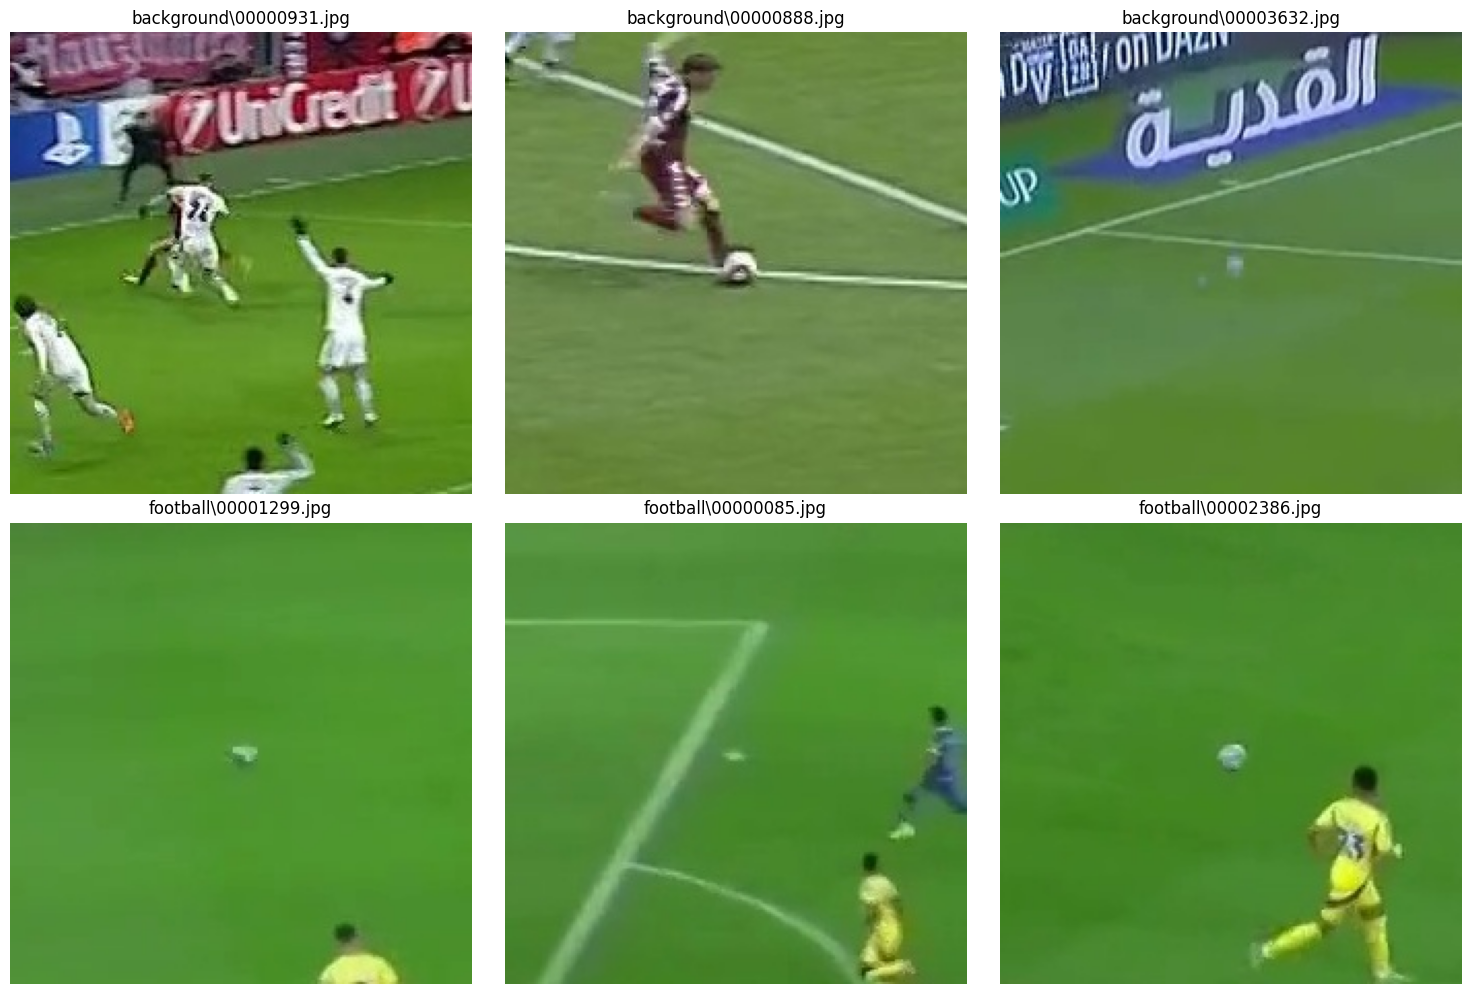

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

num_bg_images = len(bg_file_names)
num_fb_images = len(fb_file_names)

bg_images_temp = [bg_file_names[random.randint(0, num_bg_images-1)] for i in range(3)]
fb_images_temp = [fb_file_names[random.randint(0, num_fb_images-1)] for i in range(3)]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, img_path in zip(axes[0], bg_images_temp):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.split('/')[-1])

for ax, img_path in zip(axes[1], fb_images_temp):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.split('/')[-1])

plt.tight_layout()
plt.show()

#### From manually observing 10 sets of 3 random images, I found that around 1/5th of the background images contain footballs.
***While this has no direct implications, I can rest assured that quite a few of the images have been incorrectly labelled.***

In [5]:
from src.infer.torch_model import Torch_model
import torch
from torch.utils.data import Dataset, DataLoader

custom_pretrained_model_path = "./custom_pretrained_model/model.pt"

IMG_W = 640
IMG_H = 640
CONF_THRESH = 0.6 # i'm setting the threshold to 0.6 because the training logs mention that the best threshold was 0.6
BATCH_SIZE = 4

model = Torch_model(
    model_name="l",
    model_path=custom_pretrained_model_path,
    n_outputs=1,
    input_width=IMG_W,
    input_height=IMG_H,
    conf_thresh=CONF_THRESH,
    keep_ratio=True,
)
model.device = "cuda" if torch.cuda.is_available() else "cpu"
print(model.device)

2025-08-10 20:40:56.698 | INFO     | src.infer.torch_model:_load_model:74 - Torch model, Device: cuda, AMP: False


cuda


In [6]:
# here i'll test how the model works for 5 random images each from the background and football folders
import cv2

# background images
print("Output for background images:")
for i in range(5):
    idx = random.randint(0, num_bg_images-1)
    img = cv2.imread(bg_file_names[idx])
    img_resized = cv2.resize(img, (IMG_W, IMG_H))
    res = model(img_resized)
    print(res)

print()

# football images
print("Output for football images:")
for i in range(5):
    idx = random.randint(0, num_fb_images-1)
    img = cv2.imread(fb_file_names[idx])
    img_resized = cv2.resize(img, (IMG_W, IMG_H))
    res = model(img_resized)
    print(res)

Output for background images:
[{'labels': array([], dtype=int64), 'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}]
[{'labels': array([], dtype=int64), 'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}]
[{'labels': array([0], dtype=int64), 'boxes': array([[293.50415, 300.53174, 345.44324, 349.95605]], dtype=float32), 'scores': array([0.7367635], dtype=float32)}]
[{'labels': array([0], dtype=int64), 'boxes': array([[301.9141 , 306.66882, 344.51205, 340.16077]], dtype=float32), 'scores': array([0.7398519], dtype=float32)}]
[{'labels': array([], dtype=int64), 'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}]

Output for football images:
[{'labels': array([0], dtype=int64), 'boxes': array([[307.84857, 307.83908, 333.21844, 333.0273 ]], dtype=float32), 'scores': array([0.80619353], dtype=float32)}]
[{'labels': array([0], dtype=int64), 'boxes': array([[296.29135, 308.34753, 345.46378, 3

### Model Input/Output format

#### As can be seen in the previous example:

- **Input**:
    - img: numpy arrays of the resized image

- **Output**:
    - labels:
        - an array of ```int64``` values representing the *labels*, for each object detected in the image
        - as defined in the config.yaml file the model is a single class classification model, so label values can only be ```0```: *ball*
        - can be empty if *ball* isn't found
    - boxes:
        - an array of arrays of ```float32``` values representing the *bounding boxes* for each object detected in the image
        - can be empty if no *ball* is found
    - scores:
        - an array of ```float32``` values representing the *confidence socres*, for each object detected in the image
        - can be empty if *ball* isn't found

In [17]:
class BackgroundDataset(Dataset):  
    def __init__(self, img_paths):  
        self.paths = img_paths  
      
    def __len__(self):  
        return len(self.paths)  
      
    def __getitem__(self, idx):  
        img_path = self.paths[idx]  
        img = cv2.imread(str(img_path))  
        img_resized = cv2.resize(img, (IMG_W, IMG_H))  
        return img_resized, img_path

In [46]:
from concurrent.futures import ThreadPoolExecutor
import time
from tqdm import tqdm

def save_image(img, save_path):
    return cv2.imwrite(str(save_path), img)

def process_images(file_names, save_footballs, save_backgrounds):  
    """  
    Loads in an image dataset; processes them through an object detection model to predict if a ball exists in the image; and saves them accordingly into any of the 2 folders:  
        1. cleaned_dataset/background - folder containing cleaned background images  
        2. cleaned_dataset/football - folder containing cleaned football images  
          
    Note: "cleaned" in this context means correctly classified  
      
    @param file_names (list): list of paths to images  
    @param save_footballs (str): folder path to save images containing footballs  
    @param save_backgrounds(str): folder path to save images containing backgrounds  
    """  
    start_time = time.time()  
    dataset = BackgroundDataset(img_paths=file_names)  
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
    
    
    confusion_scores = {
            "TP": 0,
            "TN": 0,
            "FP": 0,
            "FN": 0
        }
      
    with ThreadPoolExecutor(max_workers=4) as executor:  
        for imgs, paths in tqdm(loader, total=len(loader), desc="Processing images"):  
            # Convert tensor to numpy array if needed  
            if isinstance(imgs, torch.Tensor):  
                imgs_np = imgs.numpy()  
            else:  
                imgs_np = np.array(imgs)  
              
            res_batch = model(imgs_np)
            for detections, img, path in zip(res_batch, imgs, paths):  
                if len(detections['labels']) > 0 and detections['labels'][0] == 0:  
                    # Convert tensor to numpy for saving  
                    img_np = img.numpy() if isinstance(img, torch.Tensor) else img
                    executor.submit(save_image, img_np, os.path.join(save_footballs, os.path.basename(path)))  
                else:
                    img_np = img.numpy() if isinstance(img, torch.Tensor) else img  
                    executor.submit(save_image, img_np, os.path.join(save_backgrounds, os.path.basename(path)))  
                    
                if 'background' in path:
                    if len(detections['labels']) > 0 and detections['labels'][0] == 0:
                        confusion_scores['FN'] += 1
                    else:
                        confusion_scores['TN'] += 1
                else:
                    if len(detections['labels']) > 0 and detections['labels'][0] == 0:
                        confusion_scores['TP'] += 1
                    else:
                        confusion_scores['FP'] += 1
                        
    end_time = time.time()  
    print(f"Processing completed in {end_time-start_time:.2f} seconds")      
    return confusion_scores      

In [49]:
# process a sample of random images
temp_save_footballs = './temp_cleaned/football'
temp_save_backgrounds = './temp_cleaned/background'

os.makedirs(temp_save_footballs, exist_ok=True)
os.makedirs(temp_save_backgrounds, exist_ok=True)

sample_bg_images = random.sample(bg_file_names, 20)
sample_fb_images = random.sample(fb_file_names, 20)
print(sample_bg_images)
print(sample_fb_images)

temp_confusion_scores = {
        "TP": 0,
        "TN": 0,
        "FP": 0,
        "FN": 0
    }

score_bg = process_images(file_names=sample_bg_images, save_footballs=temp_save_footballs, save_backgrounds=temp_save_backgrounds)
print(score_bg)
score_fb = process_images(file_names=sample_fb_images, save_footballs=temp_save_backgrounds, save_backgrounds=temp_save_backgrounds)
print(score_fb)

for k in temp_confusion_scores:
    temp_confusion_scores[k] += (score_bg[k] + score_fb[k])
temp_confusion_scores

['./contaminated_classifier_data/background\\00006638.jpg', './contaminated_classifier_data/background\\00007788.jpg', './contaminated_classifier_data/background\\00152423.jpg', './contaminated_classifier_data/background\\00572815.jpg', './contaminated_classifier_data/background\\00002309.jpg', './contaminated_classifier_data/background\\00155538.jpg', './contaminated_classifier_data/background\\00003655.jpg', './contaminated_classifier_data/background\\00000522.jpg', './contaminated_classifier_data/background\\00006664.jpg', './contaminated_classifier_data/background\\00010598.jpg', './contaminated_classifier_data/background\\00007985.jpg', './contaminated_classifier_data/background\\00011540.jpg', './contaminated_classifier_data/background\\00160628.jpg', './contaminated_classifier_data/background\\00008590.jpg', './contaminated_classifier_data/background\\00001912.jpg', './contaminated_classifier_data/background\\00001105.jpg', './contaminated_classifier_data/background\\00008269.jp

Processing images: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Processing completed in 6.83 seconds
{'TP': 0, 'TN': 11, 'FP': 0, 'FN': 9}


Processing images: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]

Processing completed in 6.63 seconds
{'TP': 20, 'TN': 0, 'FP': 0, 'FN': 0}


{'TP': 20, 'TN': 11, 'FP': 0, 'FN': 9}

### The following things can be noticed:

- #### the detection model produces quite a few false positives (detecting footballs where they do not exist)
    - it's worth noting that many of these images do not even contain any round figure that could be mistakenly classified as a ball
    - this is possibly caused by the low quality of images

- #### there are a few false negatives, too
    - while relatively smaller, there are a few false negatives, as well, possibly in the range of 1/10 to 1/8 images

In [52]:
# process the entire dataset

save_footballs = './cleaned_dataset/football'
save_backgrounds = './cleaned_dataset/background'

os.makedirs(save_footballs, exist_ok=True)
os.makedirs(save_backgrounds, exist_ok=True)

bg_scores = process_images(file_names=bg_file_names, save_footballs=save_footballs, save_backgrounds=save_backgrounds)

Processing images: 100%|██████████| 1138/1138 [07:10<00:00,  2.64it/s]

Processing completed in 430.46 seconds


In [53]:
# as a sanity check, i'm running the process_images function over the football images too

fb_scores = process_images(file_names=fb_file_names, save_footballs=save_footballs, save_backgrounds=save_backgrounds)

confusion_scores = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
for k in confusion_scores:
    confusion_scores[k] += bg_scores[k] + fb_scores[k]

Processing images: 100%|██████████| 1013/1013 [05:53<00:00,  2.86it/s]

Processing completed in 353.74 seconds


In [54]:
confusion_scores

{'TP': 3861, 'TN': 3263, 'FP': 189, 'FN': 1286}

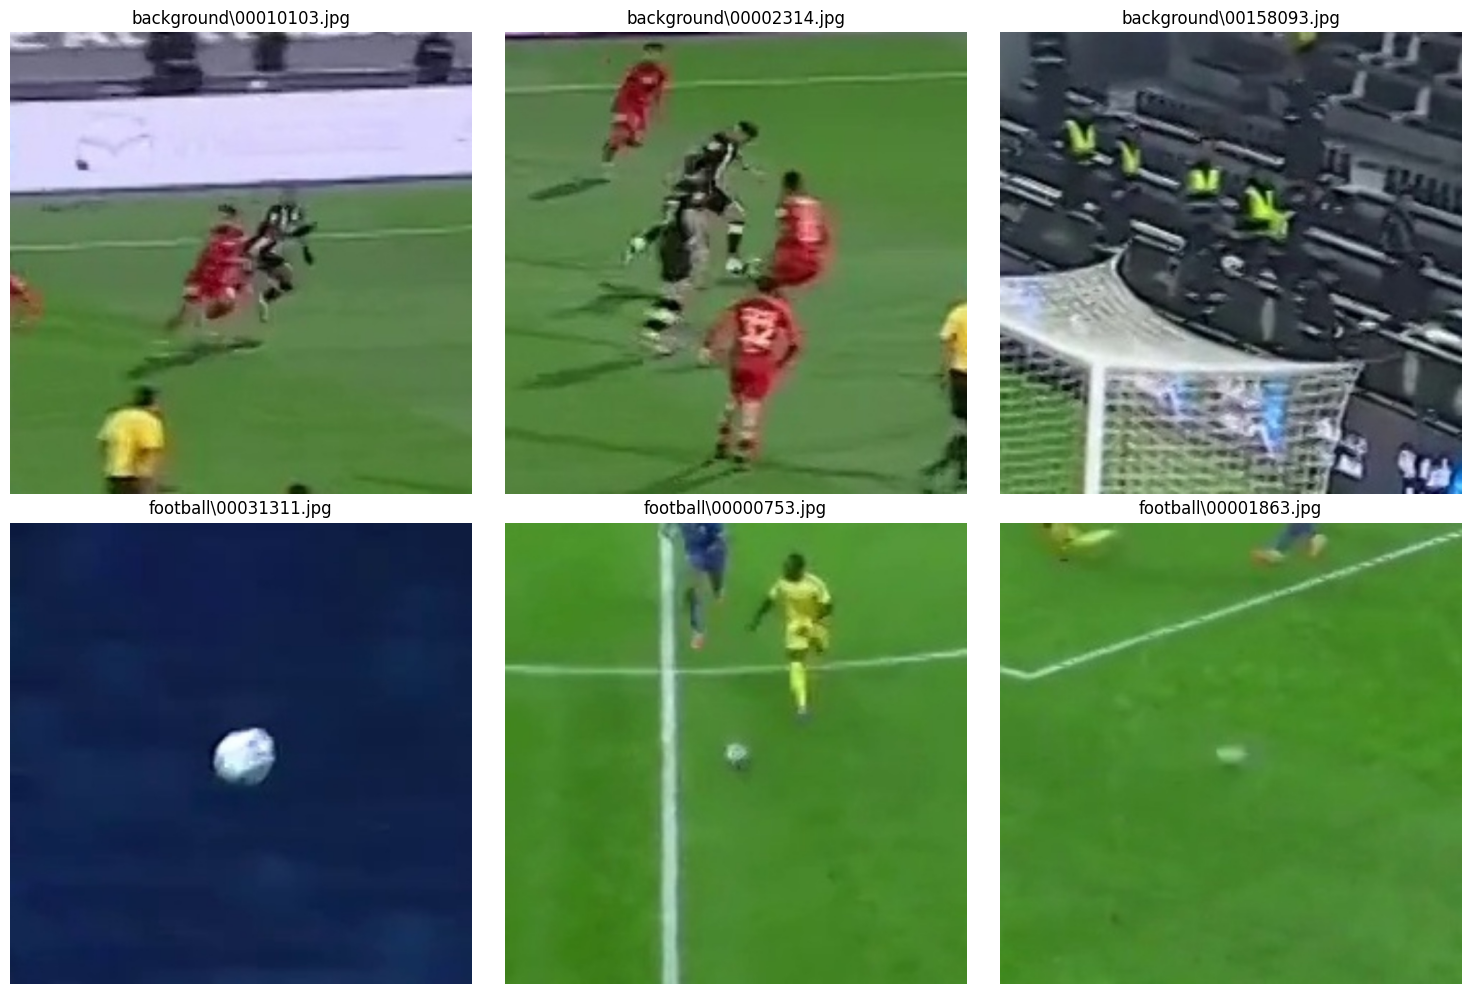

In [56]:
cleaned_fb_images = extract_file_names(save_footballs)
cleaned_bg_images = extract_file_names(save_backgrounds)

num_bg_images = len(cleaned_bg_images)
num_fb_images = len(cleaned_fb_images)

bg_images_temp = [cleaned_bg_images[random.randint(0, num_bg_images-1)] for i in range(3)]
fb_images_temp = [cleaned_fb_images[random.randint(0, num_fb_images-1)] for i in range(3)]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, img_path in zip(axes[0], bg_images_temp):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.split('/')[-1])

for ax, img_path in zip(axes[1], fb_images_temp):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.split('/')[-1])

plt.tight_layout()
plt.show()